In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.ensemble
import pathlib

# Local imports
import annotation, hyspec_cnn

In [3]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Parameters
VAL_FRAC = 0.3
BATCH_SIZE = 4

In [5]:
# Paths 
base_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS')
tiles_dataset_path = base_dir / '5c_Rad_Georef_SGC_PCA_Tiles/20210825_Olberg_PCA_TrainValDataset'
class_dict_path =  base_dir / '4c_Rad_Georef_SGC_Tiles/tile_classes_merged_NGT.json'
unet_model_save_dir = base_dir /  'X_SavedKerasModels'
tensorboard_log_dir = base_dir / 'X_TensorboardLogs'

# tiles_dataset_path = r'/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/5c_Rad_Georef_SGC_PCA_Tiles/20210825_Olberg_PCA_TrainValDataset'
# class_dict_path = r'/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4c_Rad_Georef_SGC_Tiles/tile_classes_merged_NGT.json'
# unet_model_save_dir = r'/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels'
# tensorboard_log_dir = r'/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_TensorboardLogs'

In [6]:
tiles_dataset_path

PosixPath('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/5c_Rad_Georef_SGC_PCA_Tiles/20210825_Olberg_PCA_TrainValDataset')

In [7]:
# Load class label dictionary
class_dict = {'Background':0}
class_dict.update(annotation.read_class_dict(class_dict_path))
for key,value in class_dict.items():
    print(f'{key}: {value}')

Background: 0
Sand: 1
Zostera marina: 2
Zostera marina with turf algae: 3
Rockweed: 4
Other algae: 5


In [8]:
tiles_dataset_path

PosixPath('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/5c_Rad_Georef_SGC_PCA_Tiles/20210825_Olberg_PCA_TrainValDataset')

In [9]:
# Load dataset (or, rather, pointer to dataset)
dataset = tf.data.experimental.load(str(tiles_dataset_path))

In [10]:
# Show dataset details
n_tiles = int(dataset.cardinality())
print(f'Dataset specification: {dataset}')
print(f'Number of tiles: {n_tiles}')

Dataset specification: <_LoadDataset element_spec=(TensorSpec(shape=(128, 128, 8), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.int32, name=None))>
Number of tiles: 459


In [11]:
# Get dataset shape
tile_nrows,tile_ncols,tile_nchannels = dataset.element_spec[0].shape.as_list()
print(f'{tile_nrows=}, {tile_ncols=}, {tile_nchannels=}')

tile_nrows=128, tile_ncols=128, tile_nchannels=8


In [12]:
# From https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([0.0, 1.0, 1.0, 1.0, 1.0, 1.0]) # Hard-coded for current dataset, zero weight for background
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [13]:
# Shuffle dataset (tiles are originally ordered by image) and add sample weights
dataset = dataset.shuffle(buffer_size=n_tiles)
dataset = dataset.map(add_sample_weights)

In [14]:
# Split dataset into training and validation
# Note: Doing K-fold validation on Tensorflow datasets is not straightforward,
# but can probably be done using generators. We'll do a simple split for now.
n_val_tiles = int(VAL_FRAC*n_tiles)
validation_dataset = dataset.take(n_val_tiles).batch(BATCH_SIZE)
training_dataset = dataset.skip(n_val_tiles).batch(BATCH_SIZE)
print(f'Number of batches in training dataset: {training_dataset.cardinality()}')
print(f'Number of batches in validation dataset: {validation_dataset.cardinality()}')

Number of batches in training dataset: 81
Number of batches in validation dataset: 35


In [21]:
# Create the U-Net model
unet = hyspec_cnn.unet(input_channels=tile_nchannels,
                       output_channels=len(class_dict),
                       first_layer_channels=32,
                       depth = 2)
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 8)]                                                              
                                                                                                  
 augmentation (Sequential)      (None, None, None,   0           ['input_image[0][0]']            
                                8)                                                                
                                                                                                  
 initial_convolution (Conv2D)   (None, None, None,   2336        ['augmentation[0][0]']           
                                32)                                                         

In [22]:
# Define callbacks
callbacks =[tf.keras.callbacks.ModelCheckpoint(filepath = str(unet_model_save_dir) + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5',
                                   verbose = 1),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
            tf.keras.callbacks.TensorBoard(log_dir= tensorboard_log_dir)]

In [19]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state([[2], [1]], [[0.1, 0.6, 0.3], [0.05, 0.95, 0]])
m.result().numpy()

0.5

In [20]:
m.update_state()

In [25]:
# unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), 
#              loss="sparse_categorical_crossentropy",
#              weighted_metrics=[],
#              metrics = []) # tf.keras.metrics.CategoricalAccuracy()

unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), 
             loss="sparse_categorical_crossentropy",
             weighted_metrics=[],
             metrics = ['sparse_categorical_accuracy'])

In [26]:
# Fit model to dataset
history = unet.fit(training_dataset,
                   epochs=2,
                   validation_data=validation_dataset,
                   callbacks=callbacks)

Epoch 1/2
81/81 [==============================] - ETA: 0s - loss: 0.1066 - sparse_categorical_accuracy: 0.1923
Epoch 1: saving model to /media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels/my_best_model.epoch01-loss0.08.hdf5
81/81 [==============================] - 30s 336ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.1923 - val_loss: 0.0776 - val_sparse_categorical_accuracy: 0.2430 - lr: 1.0000e-04
Epoch 2/2
81/81 [==============================] - ETA: 0s - loss: 0.0810 - sparse_categorical_accuracy: 0.2298
Epoch 2: saving model to /media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels/my_best_model.epoch02-loss0.05.hdf5
81/81 [==============================] - 27s 327ms/step - loss: 0.0810 - sparse_categorical_accuracy: 0.2298 - val_loss: 0.0548 - val_sparse_categorical_accuracy: 0.3093 - lr: 1.0000e-04


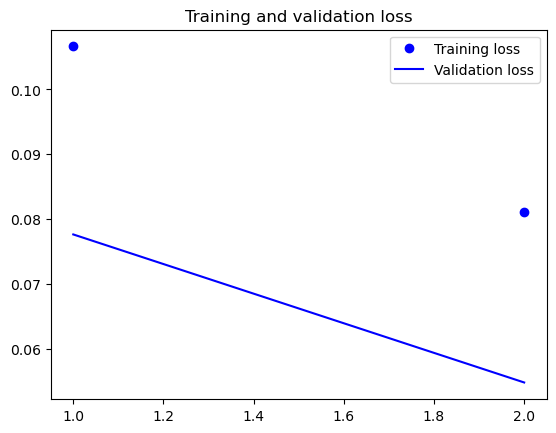

In [30]:
epochs = range(1, history.params['epochs'] + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

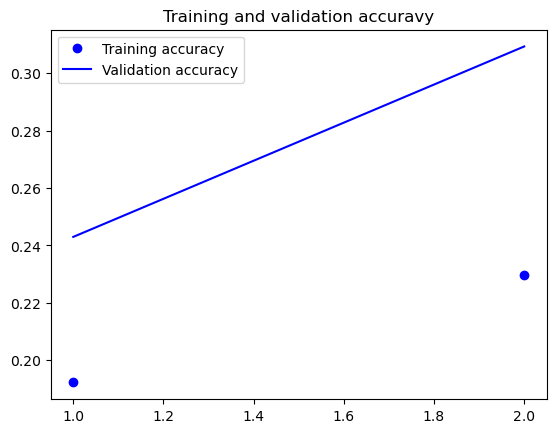

In [31]:
epochs = range(1, history.params['epochs'] + 1)
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.figure()
plt.plot(epochs, train_acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()